In [ ]:
import numpy as np
import pandas as pd
import io
import requests
from ucimlrepo import fetch_ucirepo

# Registry of supported datasets

DATASETS_URL = {
    "residential": "https://archive.ics.uci.edu/ml/machine-learning-databases/00437/Residential-Building-Data-Set.xlsx",
    "secom": "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data",
    "arrhythmia": "https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data",
}

DATASETS_ID = {"myocardial": 579}

DATASETS = DATASETS_URL | DATASETS_ID


def load_dataset_online(name_or_url):
    """
    General entry point to load any supported CSSP dataset.

    Args:
        name_or_url (str): Either a key ('residential', 'secom') or a direct URL.

    Returns:
        A (np.ndarray): Correlation matrix (p x p).
        X_norm (np.ndarray): Normalized feature matrix (N x p).
    """
    # 1. Resolve URL
    url = DATASETS_URL.get(name_or_url.lower(), name_or_url)

    print(f"  > Loading dataset: {name_or_url}")
    print(f"    Source: {url}")

    try:
        if name_or_url in DATASETS_URL:
            # 2. Download Data (Robust SSL handling)
            response = requests.get(url, verify=False)
            response.raise_for_status()
            content = io.BytesIO(response.content)

            # 3. Dispatch to specific loader based on known URLs
            if "Residential-Building" in url:
                X_raw = _parse_residential(content)
            elif "secom" in url:
                X_raw = _parse_secom(content)
            elif "arrhythmia" in url:
                X_raw = _parse_arrhythmia(content)
            else:
                # Fallback: Try generic CSV loading
                print("    Unknown format. Attempting generic CSV load...")
                df = pd.read_csv(content)
                X_raw = df.select_dtypes(include=[np.number]).to_numpy()

            if X_raw is None:
                return None, None
        elif name_or_url in DATASETS_ID:
            if "myocardial" in name_or_url:
                X = fetch_ucirepo(id=DATASETS_ID["myocardial"]).data.features
                X_raw = _parse_myocardial(X)
        # 4. Standardize and Compute Correlation (Shared Logic)
        return _standardize_and_correlate(X_raw)

    except Exception as e:
        print(f"    CRITICAL ERROR loading data: {e}")
        return None, None


# --- SPECIFIC PARSERS ---


def _parse_residential(content):
    """Parser for UCI Residential Building (Excel, Headers, targets at end)."""
    try:
        # Read Excel (Header is on row 1, index 1)
        df = pd.read_excel(content, header=1)

        # Columns 4 to 107 are the features (V-1 to V-104)
        # Drop first 4 (ID/Dates) and last 2 (Targets)
        X_df = df.iloc[:, 4:107]

        # Force numeric
        X_raw = X_df.apply(pd.to_numeric, errors="coerce").to_numpy(dtype=np.float64)
        return np.nan_to_num(X_raw)

    except Exception as e:
        print(f"    Error parsing Residential Excel: {e}")
        return None


def _parse_secom(content):
    """Parser for SECOM (Space-separated, No Header, Constant Columns)."""
    try:
        # Read CSV with space delimiter
        df = pd.read_csv(content, sep=r"\s+", header=None)
        X_raw = df.to_numpy(dtype=np.float64)

        # Fill NaNs (SECOM has many)
        X_raw = np.nan_to_num(X_raw)

        return _clean_constant_rows(X_raw, "secom")

    except Exception as e:
        print(f"    Error parsing SECOM CSV: {e}")
        return None


def _parse_arrhythmia(content):
    """Parser for Arrhythmia (Comma-separated, '?' for missing data)."""
    try:
        # FIX 1: Use sep="," (default) and handle '?' missing values
        df = pd.read_csv(content, header=None, na_values="?")

        # FIX 2: Arrhythmia often has a 'class' label in the last column
        # Usually for CSSP we only want the features (columns 0-278)
        X_df = df.iloc[:, :-1]

        # Force numeric and fill NaNs with 0
        X_raw = (
            X_df.apply(pd.to_numeric, errors="coerce")
            .fillna(0)
            .to_numpy(dtype=np.float64)
        )

        return _clean_constant_rows(X_raw, "arrhythmia")

    except Exception as e:
        print(f"    Error parsing Arrhythmia CSV: {e}")
        return None


def _parse_myocardial(content):
    try:
        X_raw = (
            content.apply(pd.to_numeric, errors="coerce")
            .fillna(0)
            .to_numpy(dtype=np.float64)
        )

        return _clean_constant_rows(X_raw, "myocardial")

    except Exception as e:
        print(f"    Error parsing Arrhythmia CSV: {e}")
        return None


# --- SHARED MATH ---


def _clean_constant_rows(X_raw, name):
    """Drop constant rows (Repeated rows)"""
    # SECOM SPECIFIC: Drop constant columns (Variance = 0)
    # If we don't do this, the matrix is singular and solver crashes.
    std_devs = np.std(X_raw, axis=0)
    keep_idx = np.where(std_devs > 1e-9)[0]

    print(
        f"    [{name} Cleaning] Dropped {X_raw.shape[1] - len(keep_idx)} constant columns."
    )
    return X_raw[:, keep_idx]


def _standardize_and_correlate(X_raw):
    """
    Normalizes X (Z-score) and calculates A = (X^T X) / N.
    Used for ALL datasets to ensure consistent math.
    """
    N, p = X_raw.shape
    print(f"    Raw Data Shape: {N} rows x {p} features")

    # Z-score Normalization
    X_mean = np.mean(X_raw, axis=0)
    X_std = np.std(X_raw, axis=0)

    # Safety: Avoid division by zero
    X_std[X_std == 0] = 1.0

    X_norm = (X_raw - X_mean) / X_std

    # Correlation Matrix
    A = (X_norm.T @ X_norm) / N

    print(f"    Computed Correlation Matrix A: {A.shape}")
    return A, X_norm


A, X = load_dataset_online("secom")


  > Loading dataset: secom
    Source: https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data


/Users/nautilus/gridfw/.venv/lib/python3.14/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


    Raw Data Shape: 1567 rows x 590 features
    Computed Correlation Matrix A: (590, 590)


In [25]:
A

array([[ 1.        , -0.04778231,  0.0075897 , ...,  0.0052334 ,
         0.00391812,  0.0214887 ],
       [-0.04778231,  1.        , -0.03044774, ...,  0.03947934,
         0.04049988,  0.04446374],
       [ 0.0075897 , -0.03044774,  1.        , ..., -0.00709043,
        -0.00912185, -0.03043445],
       ...,
       [ 0.0052334 ,  0.03947934, -0.00709043, ...,  1.        ,
         0.97433188,  0.39150294],
       [ 0.00391812,  0.04049988, -0.00912185, ...,  0.97433188,
         1.        ,  0.3898976 ],
       [ 0.0214887 ,  0.04446374, -0.03043445, ...,  0.39150294,
         0.3898976 ,  1.        ]], shape=(590, 590))

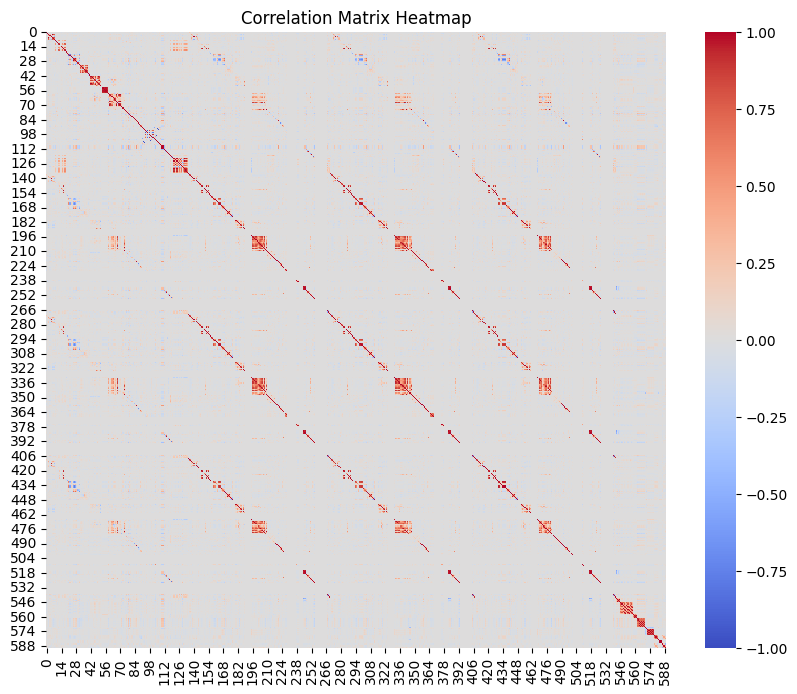

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(A, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [27]:
def get_correlation_density(A):
    p = A.shape[0]
    # Extract only off-diagonal elements
    off_diag = A[~np.eye(p, dtype=bool)]
    return np.mean(np.abs(off_diag))

print(f"Mean absolute correlation: {get_correlation_density(A):.4f}")

Mean absolute correlation: 0.0282


In [28]:
# import numpy as np
# import pandas as pd
# import io
# import requests

# # Registry of supported datasets
# DATASETS = {
#     "residential": "https://archive.ics.uci.edu/ml/machine-learning-databases/00437/Residential-Building-Data-Set.xlsx",
#     "secom": "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data",
# }


# def load_dataset(name_or_url):
#     """
#     General entry point to load any supported CSSP dataset.

#     Args:
#         name_or_url (str): Either a key ('residential', 'secom') or a direct URL.

#     Returns:
#         A (np.ndarray): Correlation matrix (p x p).
#         X_norm (np.ndarray): Normalized feature matrix (N x p).
#     """
#     # 1. Resolve URL
#     url = DATASETS.get(name_or_url.lower(), name_or_url)

#     print(f"  > Loading dataset: {name_or_url}")
#     print(f"    Source: {url}")

#     try:
#         # 2. Download Data (Robust SSL handling)
#         response = requests.get(url, verify=False)
#         response.raise_for_status()
#         content = io.BytesIO(response.content)

#         # 3. Dispatch to specific loader based on known URLs
#         if "Residential-Building" in url:
#             X_raw = _parse_residential(content)
#         elif "secom" in url:
#             X_raw = _parse_secom(content)
#         else:
#             # Fallback: Try generic CSV loading
#             print("    Unknown format. Attempting generic CSV load...")
#             df = pd.read_csv(content)
#             X_raw = df.select_dtypes(include=[np.number]).to_numpy()

#         if X_raw is None:
#             return None, None

#         # 4. Standardize and Compute Correlation (Shared Logic)
#         return _standardize_and_correlate(X_raw)

#     except Exception as e:
#         print(f"    CRITICAL ERROR loading data: {e}")
#         return None, None


# # --- SPECIFIC PARSERS ---


# def _parse_residential(content):
#     """Parser for UCI Residential Building (Excel, Headers, targets at end)."""
#     try:
#         # Read Excel (Header is on row 1, index 1)
#         df = pd.read_excel(content, header=1)

#         # Columns 4 to 107 are the features (V-1 to V-104)
#         # Drop first 4 (ID/Dates) and last 2 (Targets)
#         X_df = df.iloc[:, 4:107]

#         # Force numeric
#         X_raw = X_df.apply(pd.to_numeric, errors="coerce").to_numpy(dtype=np.float64)
#         return np.nan_to_num(X_raw)

#     except Exception as e:
#         print(f"    Error parsing Residential Excel: {e}")
#         return None


# def _parse_secom(content):
#     """Parser for SECOM (Space-separated, No Header, Constant Columns)."""
#     try:
#         # Read CSV with space delimiter
#         df = pd.read_csv(content, sep="\s+", header=None)
#         X_raw = df.to_numpy(dtype=np.float64)

#         # Fill NaNs (SECOM has many)
#         X_raw = np.nan_to_num(X_raw)

#         # SECOM SPECIFIC: Drop constant columns (Variance = 0)
#         # If we don't do this, the matrix is singular and solver crashes.
#         std_devs = np.std(X_raw, axis=0)
#         keep_idx = np.where(std_devs > 1e-9)[0]

#         print(
#             f"    [SECOM Cleaning] Dropped {X_raw.shape[1] - len(keep_idx)} constant columns."
#         )
#         return X_raw[:, keep_idx]

#     except Exception as e:
#         print(f"    Error parsing SECOM CSV: {e}")
#         return None
    
    
# def _standardize_and_correlate(X_raw):
#     """
#     Normalizes X (Z-score) and calculates A = (X^T X) / N.
#     Used for ALL datasets to ensure consistent math.
#     Note that it doesn't change anything, because N is a constant
#     """
#     N, p = X_raw.shape
#     print(f"    Raw Data Shape: {N} rows x {p} features")

#     # Z-score Normalization
#     X_mean = np.mean(X_raw, axis=0)
#     X_std = np.std(X_raw, axis=0)

#     # Safety: Avoid division by zero
#     X_std[X_std == 0] = 1.0

#     X_norm = (X_raw - X_mean) / X_std

#     # Correlation Matrix
#     A = (X_norm.T @ X_norm) / N

#     print(f"    Computed Correlation Matrix A: {A.shape}")
#     return A, X_norm

